In [1]:
%matplotlib inline
import h5py
from matplotlib import pyplot as plt
import numpy as np
from opmd_viewer import OpenPMDTimeSeries
import os
from rswarp.utilities.file_utils import *
from rswarp.utilities.beam_analysis import *

## Particle diagnostics

In [2]:
#Import phase space data from all steps. Uses readparticles()
stepArrays = loadparticlefiles('diags/xySlice/hdf5/')
steps = stepArrays.keys()
steps.sort()

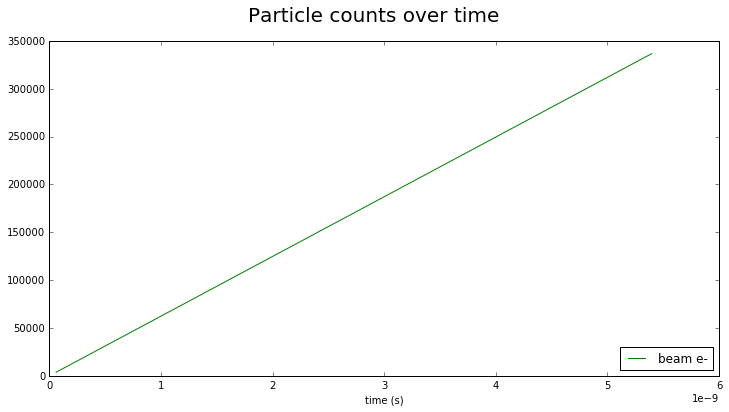

In [3]:
eleccount = [len(stepArrays[s]['e-']) for s in steps]
t = [stepArrays[s]['time'] for s in steps]

fig = plt.figure(figsize=(12,6))
plt.suptitle('Particle counts over time',fontsize=20)
plt.plot(t,eleccount,'g-', label='beam e-')
plt.xlabel('time (s)')
plt.legend(loc='lower right')

plt.show()

In [4]:
filteredsteps = []  # Disables all phase space plotting
# filteredsteps = steps[::]   # all steps
# filteredsteps = steps[-2:-1]  # last step
# filteredsteps = steps[0:1]  # first step
elecdata = [convertunits(stepArrays[s]['e-']) for s in filteredsteps]
times = [stepArrays[s]['time'] for s in filteredsteps]
if len(times) > 0:
    print("Length of data: %i steps, from %.2E to %.2E s" % (len(times),times[0],times[-1]))

In [5]:
figs = []
def plotDecorate(fig,name):
    fig.suptitle("%s phase space for step %i time %.3E s" % (name,filteredsteps[i],times[i]))
    fig.axes[4].set_xlim(0.0,1.0) # z limits
    
def emitplotDecorate(fig,name):
    fig.suptitle("%s phase space for step %i time %.3E s" % (name,filteredsteps[i],times[i]))
    fig.axes[0].set_ylim(-1000,1000)
    fig.axes[1].set_ylim(-1000,1000)
    fig.axes[4].set_xlim(0.0,1.0) # z limits

for i in range(0,len(filteredsteps)):
    for d in [
        {'data': elecdata[i], 'color': 'g', 'name': 'e-', 'fraction': 0.33, 'plotDecorate': plotDecorate}
    ]:
        data = d['data']
        if len(data) > 0:
            plotDecorate = d['plotDecorate']
            fraction = d['fraction']
            mask = np.random.choice([False, True], len(data), p=[1 - fraction, fraction])
            # print("Showing %i particles out of %i for case %s" % (sum(mask),len(data),d['name']))
            figs.append(plotphasespace(data[mask,:], color=d['color'], decorator=lambda fig: plotDecorate(fig,d['name'])))

## Field Diagnostics

In [6]:
elects = OpenPMDTimeSeries('./diags/fields/electric/')
magts = OpenPMDTimeSeries('./diags/fields/magnetic/')
# print(opmd_viewer.openpmd_timeseries.data_reader.params_reader.read_openPMD_params(ts.h5_files[0]))
%matplotlib inline
for ts in [elects,magts]:
    if ts.avail_circ_modes is None:
        ts.avail_circ_modes = []

### Electric fields

In [7]:
elects.slider()

### Expected electric field of line charge

$ E_r \approx \frac{\lambda}{2\pi r \epsilon_0} \approx \frac{I/v_z}{2\pi r \epsilon_0} $

$ E_r( r = 0.01 ~ m ) \approx 0.103 ~ V/m $

### Magnetic fields

In [8]:
magts.slider()

### Expected magnetic field of line current:

$ B_t(r) \approx \frac{\mu_0 I}{2\pi r} $

$ B_t(r = 0.01 ~ m) \approx 2 \times 10^{-10} ~ T $

In [9]:
def linePlotField(field,component,data,zslice=None,it=-1,title=None):
    (F,info) = data.get_field(field, component, iteration=data.iterations[it])
    r = np.arange(start=0, stop=info.rmax + info.dr,step=info.dr)
    r = np.hstack((-r[::-1],r)) # generate array the same way get_field does, INCLUDING the duplication of middle element
    if zslice is None:
        zslice = int(F.shape[1]/2) * info.dz
        nz = int(F.shape[1]/2)
    else:
        nz = int(zslice/info.dz)
        
    Fsliced = F[:, nz]
    
    f = plt.figure()
    plt.plot(r, Fsliced*np.sign(r))
    
    plt.xlabel('Radial position (m)')
    zlabel = ('%.2E' if nz*info.dz < 0.1 else '%.2f') % (nz*info.dz)
    plt.title('Field %s%s at position z=%s m, t=%.2E s' % (field,component,zlabel,data.t[it]), y=1.05)
    
    return f
    
def linePlotEr(data, zslice=None, it=-1):
    f = linePlotField(field='E', component='r', data=data, zslice=zslice, it=it)
    plt.ylabel('Electric field (V/m)')
    return f
    
def linePlotBt(data, zslice=None, it=-1):
    f = linePlotField(field='B', component='t', data=data, zslice=zslice, it=it)
    plt.ylabel('Magnetic field (T)')
    return f

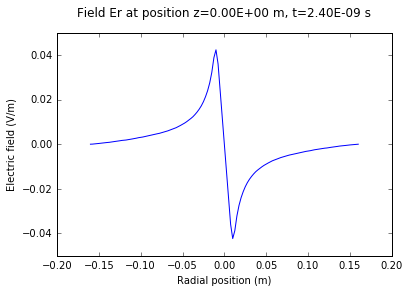

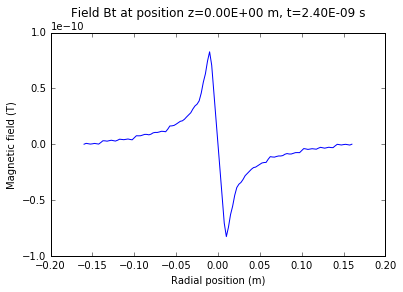

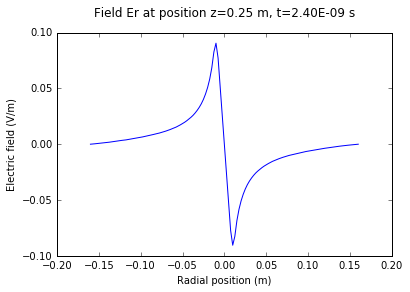

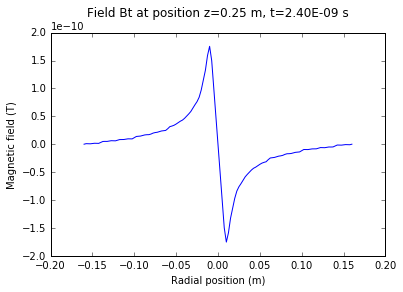

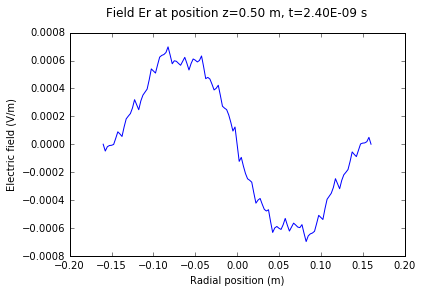

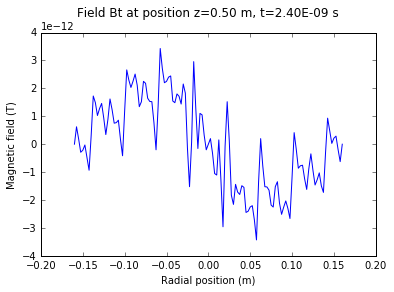

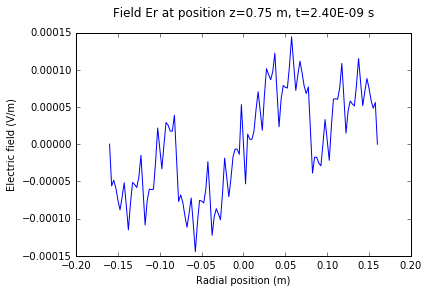

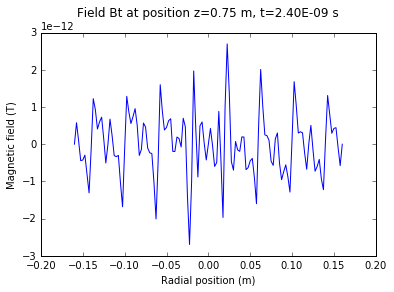

In [10]:
for z in np.arange(0.0,1.0,0.25):
    linePlotEr(elects,zslice=z,it=int(len(elects.iterations)/3))
    linePlotBt(magts,zslice=z,it=int(len(magts.iterations)/3))

/home/vagrant/.pyenv/versions/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


(-3e-10, 3e-10)

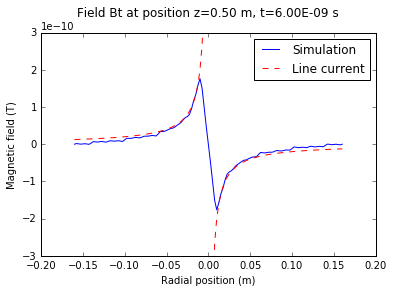

In [11]:
f = linePlotBt(magts,zslice=0.5,it=-1)
a = f.axes[0]
a.lines[0].set_label('Simulation')
r = a.lines[0].get_xdata()
plt.plot(r, -2*1e-7*10e-6/r, color='r', linestyle='--', label='Line current')
plt.legend()
plt.ylim([-3e-10,3e-10])